In [144]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [145]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import keras
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import re
import string
from wordcloud import WordCloud, STOPWORDS 
import time
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from nltk.stem import PorterStemmer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [146]:
data=pd.read_csv("gdrive/MyDrive/NLP/googleplaystore_user_reviews.csv",encoding="latin1")

In [147]:
data.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
3,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
4,10 Best Foods for You,Best way,Positive,1.00,0.300000


In [148]:
df=pd.concat([data.Translated_Review,data.Sentiment],axis=1)
df.dropna(axis=0,inplace=True)
df.head(10)

,Translated_Review,Sentiment
0,I like eat delicious food. That's I'm cooking ...,Positive
1,This help eating healthy exercise regular basis,Positive
2,Works great especially going grocery store,Positive
3,Best idea us,Positive
4,Best way,Positive
5,Amazing,Positive
6,"Looking forward app,",Neutral
7,It helpful site ! It help foods get !,Neutral
8,good you.,Positive
9,Useful information The amount spelling errors ...,Positive


In [149]:
df.Sentiment.value_counts()

Positive    23998
Negative     8271
Neutral      5158
Name: Sentiment, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


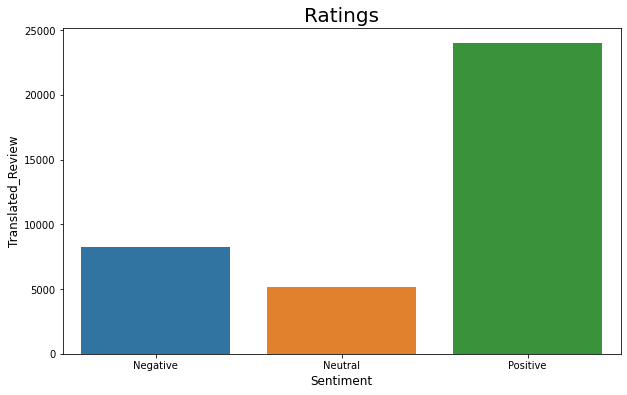

In [150]:
stars_count = df['Sentiment'].value_counts()
stars_count = stars_count.sort_index()

fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(stars_count.index, stars_count.values)
plt.title("Ratings",fontsize = 20)
plt.ylabel('Translated_Review', fontsize = 12)
plt.xlabel('Sentiment', fontsize = 12);

In [151]:
df_Sentiment=df[df.Sentiment != 3]

pd.set_option('mode.chained_assignment', None)
df_Sentiment["labels"] = df_Sentiment["Sentiment"].apply=[0 if i=="Positive" else 1 if i== "Negative" else 0 for i in df.Sentiment]
df_Sentiment = df_Sentiment.drop("Sentiment",axis=1)

df_Sentiment.head()

,Translated_Review,labels
0,I like eat delicious food. That's I'm cooking ...,0
1,This help eating healthy exercise regular basis,0
2,Works great especially going grocery store,0
3,Best idea us,0
4,Best way,0


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


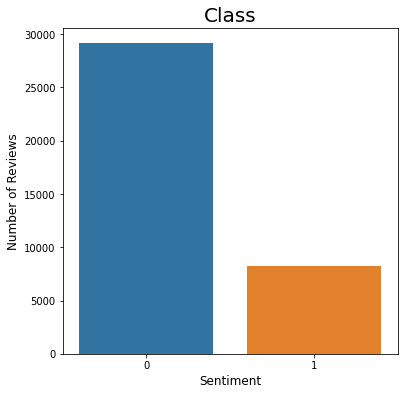

In [152]:
label_count = df_Sentiment['labels'].value_counts()
label_count = label_count.sort_index()

fig = plt.figure(figsize=(6, 6))
ax = sns.barplot(label_count.index, label_count.values)
plt.title("Class",fontsize = 20)
plt.ylabel('Number of Reviews', fontsize = 12)
plt.xlabel('Sentiment', fontsize = 12);

In [153]:
print("{:.2f}".format(df_Sentiment[df_Sentiment.labels == 0].shape[0]/df_Sentiment.shape[0]))

0.78


In [154]:
train, test = train_test_split(df_Sentiment, test_size = 0.3, stratify = df_Sentiment['labels'], random_state = 42)

In [155]:
punct = set(string.punctuation)

In [156]:
def text_prep(Translated_Review):
    #clean text
    Translated_Review = re.sub(r"n't", " not ", Translated_Review)
    Translated_Review = re.sub(r"\'s", " ", Translated_Review)
    Translated_Review = re.sub(r"\'ve", " have ", Translated_Review)
    Translated_Review = re.sub(r"\'re", " are ", Translated_Review)
    Translated_Review = re.sub(r"\'d", " would ", Translated_Review)
    Translated_Review = re.sub(r"\'ll", " will ", Translated_Review)
    
    #remove non-letters and lower case
    Translated_Review = re.sub('[^a-z\s]', '', Translated_Review.lower())
    
    #remove punctuation        
    punc_removed = [char for char in Translated_Review if char not in punct]
    punc_removed = ''.join(punc_removed)
    
    return [word for word in punc_removed.split()]

In [157]:
start_time = time.time()
cv= CountVectorizer(binary=True, analyzer = text_prep, min_df = 10, max_df = 0.95)
cv.fit_transform(train['Translated_Review'].values.astype('U'))
train_feature_set=cv.transform(train['Translated_Review'].values.astype('U'))
test_feature_set=cv.transform(test['Translated_Review'].values.astype('U'))
print("Time takes to convert text input into feature vector: ", round((time.time() - start_time)/60, 2), " mins")

Time takes to convert text input into feature vector:  0.05  mins


In [158]:
train_feature_set.shape[1]

3746

In [159]:
cv.vocabulary_['good']

1437

In [160]:
list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(1000)]

'drink'

In [161]:
y_train = train['labels'].values
y_test = test['labels'].values

In [162]:
start_time = time.time()
lr = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=1000)
lr.fit(train_feature_set,y_train)
y_pred = lr.predict(test_feature_set)
print("Time takes to train model and make predictions: ", round((time.time() - start_time)/60, 2), " mins")

Time takes to train model and make predictions:  0.0  mins


In [163]:
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),3))
print("F1: ",round(metrics.f1_score(y_test, y_pred, average='macro'),3))
print("F1: ",round(metrics.f1_score(y_test, y_pred, average='micro'),3))

Accuracy:  0.933
F1:  0.899
F1:  0.933


In [164]:
def show_word_cloud(Translated_Review):
    stopwords = set(STOPWORDS) 

    wordcloud = WordCloud(
        width = 800,
        height = 800,
        background_color ='white',
        stopwords = stopwords,
        min_font_size = 10
    ).generate(Translated_Review)
       
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

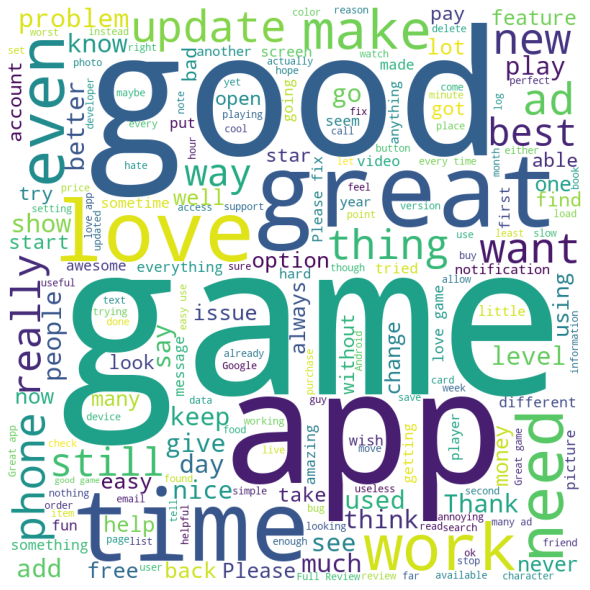

In [165]:
show_word_cloud(test['Translated_Review'].str.cat(sep=' '))